# Import libs

In [111]:
# Data manipulation
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
# Plots
# ==============================================================================
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use("fivethirtyeight")
plt.rcParams["lines.linewidth"] = 1.5
%matplotlib inline

# Warnings configuration
# ==============================================================================
import warnings

from catboost import CatBoostRegressor
from joblib import dump, load
from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import \
    ForecasterAutoregMultiOutput
from skforecast.model_selection import (backtesting_forecaster,
                                        grid_search_forecaster)
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tqdm.auto import tqdm
from tsfresh import (extract_features, extract_relevant_features,
                     select_features)
# импортируем необходимые функции из библиотеки
from tsfresh.examples.har_dataset import (download_har_dataset,
                                          load_har_classes, load_har_dataset)
from tsfresh.feature_extraction import settings
from tsfresh.utilities.dataframe_functions import impute
# Modeling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

In [189]:
# функция возвращающая график ряда в зависимости от указанной фичи и скважены
def plot_series(dataset, well_number):
    dataset.loc[dataset["y"] == well_number].plot(
        subplots=True,
        figsize=(20, 24),
        title=str(f"Скважина №{well_number}"),
        layout=(10, 2),
        grid=1,
    )

# Plan
    1. Что такое дебит нефти?
   *Дебит нефти или газа* - объем нефти или газа, поступающих в единицу времени из естественного или искусственного источника (колодца, буровой скважины и тд). Дебит является характеристикой источника (буровой скважины, трубы, колодца и тд), определяющей его способность генерировать продукт, при заданном режиме эксплуатации, зависящей от его связей с прилегающими нефте-, газо- или водоносными слоями, истощения этих слоёв, а также сезонных колебаний (для грунтовых вод).
    
    2. Попытаться восстановить распрделеления для дополнительных фич
    
    DONE
    
    3. Сделать feature extraction
    
    Не получилось, tsfresh - плохая либа :(
    
    4. Построить для первой скважины модели на основе данных (с/без дополнительных фич)
    5. По аналогии принять решение дл руги скважин, потестить подели

# Data distribution for features

Здесь создаем словарь {номер скважины: датафрейм}, выкидываем столбцы, если данных меньше 50%, заполняем оставшиеся линейной интерполяцией

In [154]:
data = pd.read_csv("data/train.csv", index_col=[0], parse_dates=[0])
data

,Номер скважины,Дебит нефти,Давление забойное,x,y,Объем жидкости,Объем нефти,Активная мощность (ТМ),Время работы (ТМ),Газовый фактор рабочий (ТМ),Давление буферное,Давление забойное от Hд,Давление забойное от Pпр,Давление линейное (ТМ),Давление на входе ЭЦН (ТМ),Дебит газа (ТМ),Дебит газа попутного,Дебит жидкости (ТМ),Коэффициент мощности (ТМ)
datetime,,,,,,,,,,,,,,,,,,,
1990-08-01,0,19.939,NaN,18670.86,5714.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-08-02,0,19.939,39.064454,18670.86,5714.86,NaN,NaN,50.851351,9.600833,NaN,NaN,33.913336,39.064454,1.887872,30.293676,3843.746667,24.25,24.250000,98.534314
1990-08-03,0,21.172,39.064487,18670.86,5714.86,NaN,NaN,52.353846,NaN,NaN,NaN,33.806090,39.064487,1.885714,30.261774,3900.955000,25.75,25.833333,99.139785
1990-08-04,0,22.529,38.965297,18670.86,5714.86,NaN,NaN,51.242424,9.600000,NaN,NaN,33.695717,38.965297,1.875851,30.212768,3874.505000,27.40,27.933333,98.744318
1990-08-05,0,22.529,38.766822,18670.86,5714.86,NaN,NaN,50.910256,9.563889,NaN,NaN,33.695717,38.766822,1.873163,30.109119,3853.696667,27.40,27.400000,98.419689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1992-04-07,105,7.646,122.180672,14230.22,22456.04,NaN,NaN,252.298969,24.000000,NaN,NaN,122.180672,99.535735,11.548286,20.536082,NaN,451.36,451.358333,72.876289
1992-04-08,105,7.639,122.182381,14230.22,22456.04,15472.802,161.526,251.647423,24.000000,NaN,NaN,122.182381,99.202518,11.556784,20.459184,NaN,450.97,450.972727,72.855670
1992-04-09,105,7.657,122.183551,14230.22,22456.04,NaN,NaN,251.713542,24.000000,NaN,13.0,122.183551,99.119048,11.583542,20.104167,NaN,452.03,452.027273,72.302083


In [155]:
def fill_missed_features_with_linear(data):
    features = list(data.columns.drop("y"))
    # data.plot(subplots=True,
    # figsize=(20, 24),
    # title=str(f'Before'),
    # layout=(10,2),
    # grid=1)
    for feature in features:
        data[feature] = data[feature].interpolate(method="linear")
    # data.plot(subplots=True,
    # figsize=(20, 24),
    # title=str(f'After'),
    # layout=(10,2),
    # grid=1)
    return data

In [156]:
def get_each_well_dict(data):
    wells = list(data["Номер скважины"].unique())
    data = data.drop(columns=["x", "y"])
    data = data.rename(columns={"Дебит нефти": "y"})
    well_dict = {well: data[data["Номер скважины"] == well] for well in wells}

    return well_dict

In [157]:
wells = get_each_well_dict(data)

Clean duplicated indexes, columns with less than 50% of data

In [158]:
for i in range(len(wells)):
    wells[i] = wells[i][~wells[i].index.duplicated(keep="first")]
    wells[i] = wells[i].asfreq(freq="D")
    wells[i] = wells[i].dropna(axis=1, thresh=int(0.5 * len(wells[i])))
    wells[i] = impute(wells[i])

# Test on first well

Зададим даты тренировочного и тестового протестируемся на 1ой скважине

In [159]:
end_train = "1992-04-10"
start_test = "1992-04-11"

In [160]:
train = wells[50].copy()
train = train.asfreq(freq="D")
train.head()

,Номер скважины,y,Давление забойное,Активная мощность (ТМ),Время работы (ТМ),Газовый фактор рабочий (ТМ),Давление забойное от Hд,Давление забойное от Pпр,Давление линейное (ТМ),Давление на входе ЭЦН (ТМ),Дебит газа (ТМ),Дебит газа попутного,Дебит жидкости (ТМ),Коэффициент мощности (ТМ)
datetime,,,,,,,,,,,,,,
1990-08-01,50,4.503,35.510012,43.348913,8.236111,596.608,41.994202,36.487562,16.069982,30.823944,987.733333,12.00,11.616667,58.666667
1990-08-02,50,4.503,33.666882,33.636364,7.200000,596.608,32.857511,33.666882,1.599833,28.975000,987.733333,12.60,12.600000,92.354167
1990-08-03,50,4.682,33.666884,32.444444,8.236111,596.608,32.850370,33.666884,1.573455,28.655476,987.733333,13.10,13.100000,93.595238
1990-08-04,50,4.914,33.716786,18.272727,7.199722,596.608,32.825143,36.487562,1.565714,28.273958,987.733333,13.75,13.750000,93.708333
1990-08-05,50,5.307,33.766689,25.750000,7.250000,596.608,32.206020,33.766689,1.556391,28.669583,987.733333,14.85,14.850000,92.958333


In [161]:
print(train.columns)
len(train.columns)

Index(['Номер скважины', 'y', 'Давление забойное', 'Активная мощность (ТМ)',
       'Время работы (ТМ)', 'Газовый фактор рабочий (ТМ)',
       'Давление забойное от Hд', 'Давление забойное от Pпр',
       'Давление линейное (ТМ)', 'Давление на входе ЭЦН (ТМ)',
       'Дебит газа (ТМ)', 'Дебит газа попутного', 'Дебит жидкости (ТМ)',
       'Коэффициент мощности (ТМ)'],
      dtype='object')


14

Train dates : 1990-08-01 00:00:00 --- 1992-04-10 00:00:00  (n=619)
Test dates  : 1992-04-11 00:00:00 --- 1992-04-14 00:00:00  (n=4)


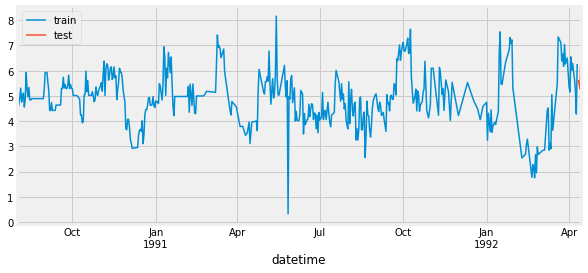

In [162]:
# Split data into train-test
# ==============================================================================
data_train = train.loc[:end_train, :]
data_test = train.loc[start_test:, :]

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})"
)

fig, ax = plt.subplots(figsize=(9, 4))
data_train["y"].plot(ax=ax, label="train")
data_test["y"].plot(ax=ax, label="test")
ax.legend();

#  Autocorrelation plots

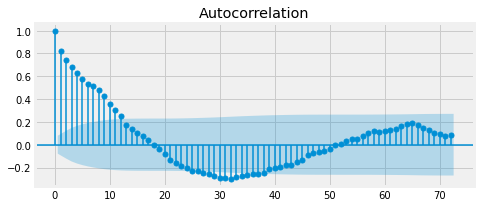

In [163]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(data_train["y"], ax=ax, lags=72)
plt.show()

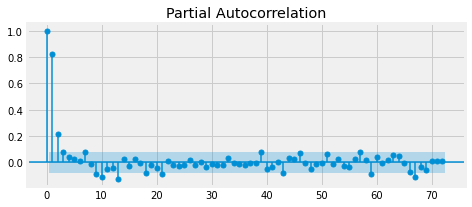

In [164]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(data_train["y"], ax=ax, lags=72)
plt.show()

# RandomForest

In [165]:
exog_variables = list(data_train.columns.drop(["y", "Номер скважины"]))
print(exog_variables)

['Давление забойное', 'Активная мощность (ТМ)', 'Время работы (ТМ)', 'Газовый фактор рабочий (ТМ)', 'Давление забойное от Hд', 'Давление забойное от Pпр', 'Давление линейное (ТМ)', 'Давление на входе ЭЦН (ТМ)', 'Дебит газа (ТМ)', 'Дебит газа попутного', 'Дебит жидкости (ТМ)', 'Коэффициент мощности (ТМ)']


In [127]:
# Hyperparameter Grid search
# ==============================================================================
steps = 90
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=123),
    lags=12,  # This value will be replaced in the grid search
)

lags_grid = [30]

param_grid = {"n_estimators": [120], "max_depth": [10]}

results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=data_train["y"],
    exog=data_train[exog_variables],
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=steps,
    refit=True,
    metric="mean_squared_error",
    initial_train_size=int(len(data_train) * 0.5),
    return_best=True,
    verbose=False,
)

Number of models compared: 1


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': 10, 'n_estimators': 120}
  Backtesting metric: 1.420179121594727



In [166]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_state=123, silent=True), lags=80
)

forecaster.fit(y=data_train["y"], exog=data_train[exog_variables])

In [167]:
# Predictions
# ==============================================================================
steps = 90

predictions = forecaster.predict(steps=steps, exog=data_train[exog_variables])

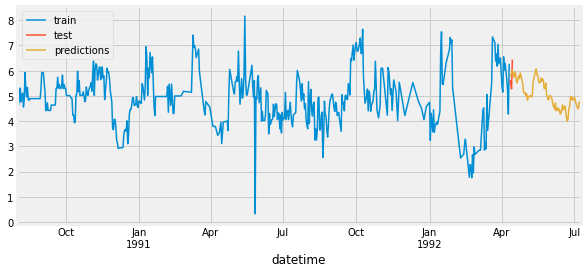

In [168]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train["y"].plot(ax=ax, label="train")
data_test["y"].plot(ax=ax, label="test")
predictions.plot(ax=ax, label="predictions")
ax.legend();

In [169]:
# Interactive plot of predictions
# ==============================================================================
data_plot = pd.DataFrame(
    {"train": data_train["y"], "test": data_test["y"], "prediction": predictions,}
)
data_plot.index.name = "date_time"

fig = px.line(
    data_frame=data_plot.reset_index(),
    x="date_time",
    y=data_plot.columns,
    title="Number of users",
    width=900,
    height=500,
)

fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [171]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data_train["y"],
    exog=data_train[exog_variables],
    initial_train_size=90,
    fixed_train_size=False,
    steps=90,
    refit=True,
    metric="mean_squared_error",
    verbose=True,
)

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 90
Number of observations used for backtesting: 529
    Number of folds: 6
    Number of steps per fold: 90
    Last fold only includes 79 observations.

Data partition in fold: 0
    Training:   1990-08-01 00:00:00 -- 1990-10-29 00:00:00
    Validation: 1990-10-30 00:00:00 -- 1991-01-27 00:00:00
Data partition in fold: 1
    Training:   1990-08-01 00:00:00 -- 1991-01-27 00:00:00
    Validation: 1991-01-28 00:00:00 -- 1991-04-27 00:00:00
Data partition in fold: 2
    Training:   1990-08-01 00:00:00 -- 1991-04-27 00:00:00
    Validation: 1991-04-28 00:00:00 -- 1991-07-26 00:00:00
Data partition in fold: 3
    Training:   1990-08-01 00:00:00 -- 1991-07-26 00:00:00
    Validation: 1991-07-27 00:00:00 -- 1991-10-24 00:00:00
Data partition in fold: 4
    Training:   1990-08-01 00:00:00 -- 1991-10-24 00:00:00
    Validation: 1991-10-25 00:00:00 -- 1992-01-22 00:00:00
Data p

IndexError: index -11 is out of bounds for axis 0 with size 10

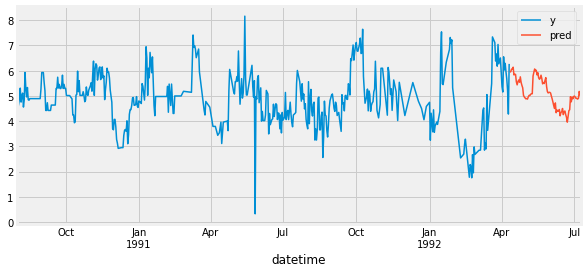

In [146]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train["y"].plot(ax=ax)
predictions.plot(ax=ax)
ax.legend();

## Let's try to GridSearch for all wells with CatBoost

Сделаем GridSearch для всех скважин

In [108]:
%%time
data0 = wells[9].copy()

data_train = data0.loc[:end_train, :]
exog_variables = list(data_train.columns.drop(["y", "Номер скважины"]))

steps = 90
forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(random_state=123, silent=True), lags=12
)

lags_grid = [80]

param_grid = {
    "n_estimators": [1000, 900],
    "max_depth": [1],
    "learning_rate": [0.05, 0.06],
}

results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=data_train["y"],
    exog=data_train[exog_variables],
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=steps,
    refit=False,
    metric="mean_squared_error",
    initial_train_size=int(len(data_train) - 90),
    return_best=True,
    verbose=False,
)

Number of models compared: 4


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:03<00:00,  3.81s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] 
  Parameters: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 900}
  Backtesting metric: 74.65937969606006

Wall time: 4.56 s


In [109]:
def get_best_params(wells):
    for i in tqdm(range(len(wells))):
        print(f"Starting well №{i}")
        data = wells[i].copy()

        data_train = data.loc[:end_train, :]

        steps = 90
        forecaster = ForecasterAutoreg(
            regressor=CatBoostRegressor(random_state=123, silent=True), lags=12
        )

        lags_grid = [73]

        param_grid = {
            "n_estimators": [700, 500, 1000, 1200],
            "max_depth": [3, 5],
            "learning_rate": [0.1],
        }

        results_grid = grid_search_forecaster(
            forecaster=forecaster,
            y=data_train["y"],
            param_grid=param_grid,
            lags_grid=lags_grid,
            steps=steps,
            refit=False,
            metric="mean_squared_error",
            initial_train_size=int(len(data_train) - 90),
            return_best=True,
            verbose=False,
        )
        best_param_dict[i] = {
            "n_lags": len(results_grid.iloc[0, :].lags),
            "params": results_grid.iloc[0, :].params,
        }

    return best_param_dict

In [21]:
best_param_dict = {}

In [22]:
best_params = get_best_params(wells)

  0%|          | 0/106 [00:00<?, ?it/s]

Starting well №0
Number of models compared: 8


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:55<00:00, 55.19s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1200}
  Backtesting metric: 22.071004731554865

Starting well №1
Number of models compared: 8


loop lags_grid:   0%|                                               | 0/1 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import json

with open("best_param_grid_without_exog.json", "w") as fp:
    json.dump(best_params, fp)

## Predict for each well

In [941]:
all_predictions = pd.DataFrame()

In [927]:
i = 0
data = wells[i].copy()
data_train = data.loc[:end_train, :]

exog_variables = list(data_train.columns.drop(["y", "Номер скважины"]))

forecaster = ForecasterAutoreg(
    regressor=CatBoostRegressor(**best_params[0]["params"], silent=True),
    lags=best_params[i]["n_lags"],
)

forecaster.fit(y=data_train["y"], exog=data_train[exog_variables])

steps = 90

predictions = pd.DataFrame()
predictions["forecast"] = forecaster.predict(
    steps=steps, exog=data_train[exog_variables]
)
predictions["Номер скважины"] = i
predictions["datetime"] = predictions.index

predictions = predictions[["datetime", "forecast", "Номер скважины"]]

all_predictions = pd.concat(
    [all_predictions, predictions], ignore_index=False, sort=False
)

In [942]:
def get_predictions(wells_dict, params_dict):
    all_predictions = pd.DataFrame()
    for i in tqdm(range(len(wells))):
        print(f"Predition well №{i}")

        data = wells[i].copy()
        data_train = data.loc[:end_train, :]

        forecaster = ForecasterAutoreg(
            regressor=CatBoostRegressor(**best_params[i]["params"], silent=True),
            lags=best_params[i]["n_lags"],
        )

        forecaster.fit(y=data_train["y"])

        steps = 90

        predictions = pd.DataFrame()
        predictions["forecast"] = forecaster.predict(steps=steps)
        predictions["Номер скважины"] = i
        predictions["datetime"] = predictions.index

        predictions = predictions[["datetime", "forecast", "Номер скважины"]]

        all_predictions = pd.concat(
            [all_predictions, predictions], ignore_index=False, sort=False
        )

    return all_predictions

In [943]:
well_predictions = get_predictions(wells, best_params)

  0%|          | 0/106 [00:00<?, ?it/s]

Predition well №0
Predition well №1
Predition well №2
Predition well №3
Predition well №4
Predition well №5
Predition well №6
Predition well №7
Predition well №8
Predition well №9
Predition well №10
Predition well №11
Predition well №12
Predition well №13
Predition well №14
Predition well №15
Predition well №16
Predition well №17
Predition well №18
Predition well №19
Predition well №20
Predition well №21
Predition well №22
Predition well №23
Predition well №24
Predition well №25
Predition well №26
Predition well №27
Predition well №28
Predition well №29
Predition well №30
Predition well №31
Predition well №32
Predition well №33
Predition well №34
Predition well №35
Predition well №36
Predition well №37
Predition well №38
Predition well №39
Predition well №40
Predition well №41
Predition well №42
Predition well №43
Predition well №44
Predition well №45
Predition well №46
Predition well №47
Predition well №48
Predition well №49
Predition well №50
Predition well №51
Predition well №52
Pre

In [945]:
well_predictions.to_csv("CatBoost_forecast.csv", index=False, encoding="utf=8")

In [944]:
well_predictions

,datetime,forecast,Номер скважины
1992-04-11,1992-04-11,12.016538,0
1992-04-12,1992-04-12,12.508334,0
1992-04-13,1992-04-13,14.401298,0
1992-04-14,1992-04-14,15.946103,0
1992-04-15,1992-04-15,16.005767,0
...,...,...,...
1992-07-05,1992-07-05,8.915855,105
1992-07-06,1992-07-06,9.078176,105
1992-07-07,1992-07-07,8.795453,105
1992-07-08,1992-07-08,8.890089,105
